In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict
from dotenv import load_dotenv

load_dotenv()

f:\Gen AI Repos\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
model = ChatOpenAI(
    model= "gpt-3.5-turbo"
)

In [3]:
class BatsmanState(TypedDict):

    runs: int
    balls: int
    fours: int
    sixes: int

    sr: float
    bpb: float
    boundary_percent: float
    summary: str

In [5]:
def calculate_sr(state: BatsmanState):

    sr = (state['runs']/state["balls"])*100

    return {"sr": sr}

In [6]:
def calculate_bpb(state: BatsmanState):

    bpb = state['runs'] / (state['fours'] + state['sixes'])

    return {"bpb": bpb}

In [7]:
def calculate_bounday_percentage(state: BatsmanState):

    boundary_percentage = (state['fours']*4 + state['sixes']*6) / state["runs"]

    return {"boundary_percent": boundary_percentage }

In [8]:
def create_summary(state: BatsmanState):

    prompt = f"""Create a Summary based on below data.
    Strike rate - {state["sr"]},
    Balls per boundary - {state["bpb"]},
    Boundary Percentage - {state["boundary_percent"]}
    """

    result = model.invoke(prompt)

    summary = result.content

    state["summary"] = summary

    return state 

In [10]:
# Creating a Parallel Workflow

graph = StateGraph(BatsmanState)

graph.add_node("calculate_sr", calculate_sr)
graph.add_node("calculate_bpb", calculate_bpb)
graph.add_node("calculate_bounday_percentage", calculate_bounday_percentage)
graph.add_node("create_summary", create_summary)


graph.add_edge(START, "calculate_sr")
graph.add_edge(START, "calculate_bpb")
graph.add_edge(START, "calculate_bounday_percentage")


graph.add_edge("calculate_sr", "create_summary")
graph.add_edge("calculate_bpb", "create_summary")
graph.add_edge("calculate_bounday_percentage", "create_summary")


graph.add_edge("create_summary", END)

workflow = graph.compile()

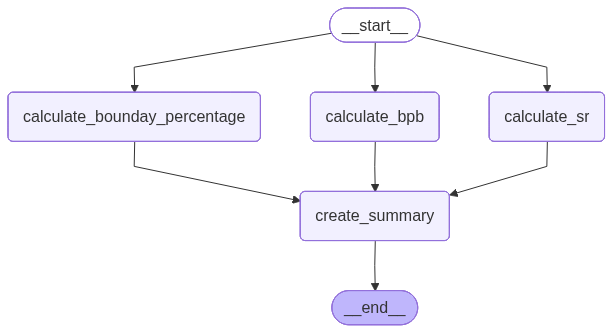

In [11]:
workflow

In [12]:
intial_state = {
    'runs': 100,
    'balls': 50,
    'fours': 6,
    'sixes': 4
}

final_state = workflow.invoke(intial_state)


In [13]:
print(final_state)

{'runs': 100, 'balls': 50, 'fours': 6, 'sixes': 4, 'sr': 200.0, 'bpb': 10.0, 'boundary_percent': 0.48, 'summary': "Based on the data provided:\n- The player's strike rate is exceptionally high at 200.0, indicating that they score runs quickly.\n- On average, the player hits a boundary every 10.0 balls faced.\n- The player's boundary percentage is 0.48, which means that nearly half of the runs scored are through boundaries. This indicates that the player is effective at hitting boundaries and scoring quickly."}


In [14]:
print(final_state["summary"])

Based on the data provided:
- The player's strike rate is exceptionally high at 200.0, indicating that they score runs quickly.
- On average, the player hits a boundary every 10.0 balls faced.
- The player's boundary percentage is 0.48, which means that nearly half of the runs scored are through boundaries. This indicates that the player is effective at hitting boundaries and scoring quickly.
